--- 
Summer 2020, M.Sc. Economics | University of Bonn | [Madhurima Chandra](https://github.com/mchandra12)

# Replication of Libertad González (2013) - Microeconometrics Project 
  ### Madhurima Chandra
---

This project replicates the core results of:

> González, Libertad. 2013. "The Effect of a Universal Child Benefit on Conceptions, Abortions, and Early Maternal Labor Supply." American Economic Journal: Economic Policy, 5 (3): 160-88.

#### Viewing this notebook:

1.  Recommended: Clone [this repository](https://github.com/HumanCapitalAnalysis/microeconometrics-course-project-mchandra12) to your local machine and access this notebook by launching ```jupyter lab``` or ```jupyter notebook``` in your shell.

2.  `mybinder` or `nbviewer` may have issues displaying images. All images of DAGs can be found in the folder 'causal_graphs'.


#### Relevant information on individual contributions:

- All replicated result tables are presented in the same order as they appear in the original paper.

- I have successfully replicated all tables (I skip one since it does not form part of the main results). Wherever there is any deviation/missing result, I document the reason thoroughly.

- Coming to figures, note that no code has been provided by the author. Going by the (at times, minimal) description in the paper, I have generated plots that mostly look identical to the originals. However, at certain points where I think doing so adds valuable insights to the interpretation of the figures, I choose to deviate. 

- The original paper alongwith datasets and STATA code provided by the author can be accessed [here](https://www.aeaweb.org/articles?id=10.1257/pol.5.3.160).
 

## Table of Contents

[1. Introductory Overview](#intro) 

 - [1.1 Institutional Setting](#ins)

[2. Visualizing Identification](#cg)

[3. Methodology and Data](#meth)

 - [3.1 Empirical Strategy](#empi)
   
 - [3.2 Datasets and Descriptive Statistics](#data)

[4. Replication of Core Results](#repli)

 - [4.1 Fertility (Conceptions and Abortions)](#ferti)
   
 - [4.2 Household Expenditure](#expen)

 - [4.3 Labor Supply Outcomes](#ls)

 - [4.4 Child Care Outcomes](#cc)

[5. Extension](#exten)
   
 - [5.1 A Closer Look at the DID specification for Child Care Results](#speci)

 - [5.2 Visual Check for Autocorrelation](#acf)


[References](#refs)

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.formats.style
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm_api
import matplotlib.pyplot as plt
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

In [5]:
from auxiliary.run_regressions import *
from auxiliary.pre_process_datasets import *
from auxiliary.generate_tables import *
from auxiliary.generate_figures import *

---
<a id='intro'></a>
# 1. Introductory Overview
---

In this paper, the author presents the causal estimates of the effect of a universal child benefit implemented nation-wide in Spain in July 2007, on fertility, household expenditure, maternal labor supply and child care-related expenditure. Hence this study falls under the purview of program evaluation and causal inference. 

In presenting the estimates, she utilizes a a variant of the well-known research design of Regression Discontinuity, that is the Regression Discontinuity in Time design. The RDiT design is an RD design wherein the running variable is time. Specifically, in our context it is months. This property of the running variable makes it appreciably different from conventional cross-sectional RD studies, in ways I discuss in forthcoming sections.

The RDiT study involves a natural experiment conducted by the Spanish government in July of 2007, which involved giving out 'baby-checks', or a child benefit given to every household where the mother has given birth after the cut-off date of July 1st, 2007. Families who had children on or before June 30th fall into the control group. Importantly, this policy was unannounced till July 3rd, hence no household had previous knowledge that would have allowed them to sort themselves into the treatment group. 

The author's results suggest that the policy lead to a significant increase in fertility, due to an underlying increase in conceptions alongwith a reduction in abortions. No significant effect is found on overall household expenditures. She also explored if the policy had any unintended effects on maternal labor supply in the aftermath of giving birth, and found short-term effects that dissipate by the child's second birthday.

---
<a id='ins'></a>
## 1.1 Institutional Setting
---

The policy of child benefit to all Spanish households was announced by the President on July 3rd. The one-time subsidy would involve giving out a sum of 2500 Euros to each family that has a newborn on or after July 1st.
The ideal experiment in this context would be wherein families are randomly selected into treatment, and the outcomes for the treatment and control groups are studied to derive credible causal effects. This type of randomization is achieved by exploiting the arbitrary nature of the treatment assignment, that is the date of July 1 is completely arbitrary. The only factor distinguishing households in the treatment group (those who received the benefit) from the control group is their treatment status.

The possibility of the existence of _non-compliers_, which could potentially lead to bias in our estimates, is fairly low. This is because the benefit was truly 'universal' in the nation-wide context. There was no income test, and application merely involved the filling out of a one-page form. The author states that government data suggests that upto 95% of all births in 2008 (the year right after the year of the implementation of treatment policy) received the benefit.

Another possibility that could lead to biased estimates, is the issue of _self-selection_ into treatment. The fact that the implementation of the policy was announced only on July 3rd, is favorable from an econometrician's perspective, since this precludes the possibility of some women choosing to postpone giving birth by a few days in order to receive treatment.

The policy was implemented by the government with the express intention to increase fertility. The author uses a novel way to estimate the effect of this policy on fertility, by studying conceptions and abortions, instead of focusing on births. Conceptions are estimated from data on number of births and gestation weeks. I describe the methodology in detail below.


---
<a id='cg'></a>
# 2. Visualizing Identification with DAGs
---

Below I present two causal graphs, which serve as a useful tool to inspect the identification strategy and its possible drawbacks. These have been created using the very useful tool [Dagitty](dagitty.net). The first DAG focuses on the causal relationships between the variables involved in the fertility analysis conducted by the author.

<img src="causal_graphs/dagitty-model11.png" width="600" />

**T**: Time (Running Variable)

**D**: Treatment indicator

**Y_C**: Outcome variable - Number of monthly conceptions

**Y_A**: Outcome variable - Number of monthly abortions

**B**: Number of births (collider)

**U**: Unobservables


Note that the treatment indicator D has a slightly different interpretation in each of these causal graphs. In the first $D$ refers to the introduction of the child benefit policy, that is treatment refers to having the knowledge of its existence and the effect knowing this has on numbers of conceptions and abortions. On the other hand, D in the second graph refers to having received the child benefit.

The time variable T (months), through seasonality effects, affects our outcomes of interest - $Y_C$ (estimated number of monthly conceptions) and $Y_A$ (estimated number of monthly abortions). To control for this seasonality, the author utilizes dummy variables for calendar months in all the specifications relating to monthly fixed effects. Hence, this possible channel is accounted for and the node for time variable (T) in the above graph is colored white (which implies an adjusted variable in Dagitty). Note that this possible channel is controlled for in her DID calculations, and not all the RDD specifications.

An interesting point of note here is that the number of abortions $Y_A$ is affected by the number of conceptions $Y_C$. Changes in the number of conceptions can have an effect on the number of abortions. Hence our estimates of the treatment effect of $D$ on $Y_A$ will be indicative of the effects of both $D$ and $Y_C$ on $Y_A$.

The back-door paths here are $D \leftarrow T \rightarrow Y_C$ and $D \leftarrow T \rightarrow Y_A$. The effect of $D$ on $Y_C$ and $Y_A$ is confounded by time $T$. This channel is accounted for by the inclusion of linear, quadratic and at times, cubic time trends.

$U$ refers to unobservables (from the econometrician's perspective) that may have a discontinuous effect on our potential outcomes at the cut-off point. The identifying assumption of the RDD is that such unobservable factors do not exist.

The number of conceptions is a variable that is not perfectly observable to the econometrician, it can only be estimated from the number of births (and gestation months as done by Gonzalez). The variable number of births $B$ is a collider variable, since both the potential outcomes $Y_C$ and $Y_A$ directly affect it. This brings to light a plausible problem with the author's strategy to calculate number of conceptions. We base our estimation of number of conceptions solely on number of births (and gestation months), without taking into account that there must have been conceptions which were aborted afterwards, those conceptions never made it to our calculations.


<img src="causal_graphs/dagitty-model2.png" width="600" />

**T**: Time (Running Variable)

**D**: Treatment indicator

**Y_HE**: Outcome variable - Household Expenditure

**Y_LS**: Outcome variable - Labor Supply
    
**Y_DC**: Outcome variable - Daycare Expenditure

**C**: Other covariates (characterisitcs such as education level of mother etc)

**U**: Unobservables

This DAG represents the analysis conducted by Gonzalez on the effect of the policy on household expenditure, maternal labor supply outcomes and daycare usage. Here, $D$ refers to having received the benefit. Treatment group comprises those who received it and control group constitutes those who did not.

As in the previous DAG, the back-door paths $D \leftarrow T \rightarrow Y_{HE}$, $D \leftarrow T \rightarrow Y_{LS}$ and $D \leftarrow T \rightarrow Y_{DC}$ are closed by the inclusion of linear, quadratic (and at times, cubic) polynomial time trends in the specifications.
Analogous to the first causal graph, seasonality effects are controlled for, hence the channels $T \rightarrow Y_{HE}$, $T \rightarrow Y_{LS}$ and $T \rightarrow Y_{DC}$ are adjusted.

$C$, which refers to covariates such as personal characteristics of the mother, do affect the potential outcomes, but do not affect the treatment indicator $D$.

**Note:** It is somewhat blurred in the DAG presented  above that I have drawn simulataneous causality between the potential outcomes $Y_{DC}$ and $Y_{LS}$. I think it is quite reasonable to think that those who are involved in labor supply (have jobs) may be more inclined towards investing in daycare for their children. Also, those who do (or do not) have access to day care may be more (or less) likely to join the workforce. This is not accounted for in the author's regressions.


---
<a id='meth'></a>
# 3. Methodology and Data

### Important differences between RDD nad RDiT research designs

In studying RDiT designs, I found Hausman and Rapson (2018) to be particularly enlightening in fleshing out how having time series data in an RDD context can lead to unforeseen problems in our calculations. The points I mention below are adapted from Hausman and Rapson (2018).

- The cross-sectional RD setting revolves around the core idea of considering observations extremely close to the cut-off; observations need to be close enough to the cut-off such that despite being on either side of the cutoff, they are comparable. One side serves as the counterfactual for the other. This is not feasible in an RDiT setting. Expanding the time frame (time being the running variable) is necessary to achieve sufficient statistical power.

- In an ideal cross-sectional RDD setting, only a few select (or better, none at all) covariates need to be controlled for in our regression. This is rarely the case in an RDiT setting. In this paper as well, we control for a considerable number of variables in our calculations.

- In time series data, there is only one observation per discrete unit of time. This makes certain robustness checks which have become an integral part of the toolkit of the RD practitioner (eg. McCrary density test to check for self-selection around the cut-off), unavailable to the RDiT researcher.

 

---
<a id='empi'></a>
## 3.1. Empirical Strategy
---

In her paper Gonzalez denotes the binary treatment indicator by _post_. In this notebook, in line with standard literature on causal inference, I choose to denote it by _D_. Below are the regression specifications employed by the author in her analysis. In equation 1, $C_m$ refers to the log of (estimated) number of conceptions in month $m$, binary treatment dummy is $D$, $X_m$ refers to number of days in month $m$. It does not account for seasonality (no calender month dummies). <a id='eq1'></a>

\begin{align*}
\text{(1)} \qquad C_m = \alpha + \gamma_1 m + \gamma_2 (m \cdot D) + \beta \cdot D + \lambda X_m + \epsilon_m.
\end{align*}

Gonzalez recognizes the problem seasonal patterns in births and conceptions can create in her identification strategy, and hence also applies the following regression equation to conceptions and abortions. Specifications with calendar month dummies follow the form: <a id='eq2'></a>

\begin{align*}
\text{(2)} \qquad C_m = \alpha + \gamma_1 m + \gamma_2 (m \cdot D) + \beta \cdot D + \lambda X_m + \sum_{c=2}^{12} \mu_c \cdot month_m + \epsilon_m.
\end{align*}

Turning to labor supply decisions, the following regression equations are estimated: <a id='eq3'></a>

\begin{align*}
\text{(3)} \qquad Y_{im} = \alpha + \gamma_1 m + \gamma_{2} (m \cdot D) + \beta \cdot D + \mathbf{\Pi} \mathbf{X}^T_{im} + \epsilon_{im}.
\end{align*}

This specification is similar to equation (1), but in addition has the subscript $i$ denoting an individual household. The vector $\mathbf{X}_{im}$ has household-level controls, which are the characteristics ($C$ in the causal graphs) giving information on each household. A specification with monthly fixed effects is also estimated: <a id='eq4'></a>

\begin{align*}
\text{(4)} \qquad Y_{im} = \alpha + \gamma_1 m + \gamma_{2} (m \cdot D) + \beta \cdot D + \mathbf{\Pi} \mathbf{X}^T_{im} + \sum_{c=2}^{12} \mu_c \cdot month_m + \epsilon_{im}.
\end{align*}

---
<a id='data'></a>
## 3.2. Datasets and Descriptive Statistics
---

Datasets in .dta format (provided by the author) for recreating paper results:

   - data_abortions_20110196.dta: data for analysis on conceptions
   - data_births_20110196.dta: data for abortions results
   - data_hbs_20110196.dta: household budget survey results
   - data_lfs_20110196.dta: for maternal labor supply analysis
   
Below I present the descriptive statistics of for all datasets, with column variable names changed to be easily read and understood by the reader.

In [20]:
create_df1_ds() # Birth and Conceptions dataset

,number_conceptions,post_policy_conception,conception_month
mean,38020.642,0.250,-30.500
std,3167.548,0.435,34.785
50%,38505.000,0.000,-30.500


In [21]:
create_df2_ds() # Abortions dataset

,number_abortions,post_policy_abortion,abortion_month
mean,6724.625,0.250,-30.500
std,1348.065,0.435,34.785
50%,6535.500,0.000,-30.500


In [6]:
create_df3_ds() # Survey data for Household Budget

,Total Expenditure,Child Related Expenditure,Durable expenditure,Day care expenditure,Post-June 2007 dummy,Month of birth,Age of mother,Mother some secondary,Mother High School Graduate,Mother College Graduate,Mother Immigrant,Not first born
mean,30507.152,4778.250,5654.333,305.794,0.487,-0.780,32.521,0.234,0.326,0.320,0.165,0.539
std,17721.420,4274.954,8740.152,848.094,0.500,5.056,5.448,0.423,0.469,0.467,0.371,0.499
50%,26144.552,3561.401,2276.193,0.000,0.000,-1.000,33.000,0.000,0.000,0.000,0.000,1.000


In [7]:
create_df4_ds() # Survey data for maternal labor supply 

,Worked Last week,Currently Employed,Post-June 2007 dummy,Month of birth,Age of mother,Mother some secondary,Mother High School Graduate,Mother College Graduate,Mother Immigrant,Not first born
mean,0.422,0.541,0.477,-0.815,32.376,0.236,0.343,0.297,0.170,0.523
std,0.494,0.498,0.499,5.128,5.252,0.425,0.475,0.457,0.376,0.500
50%,0.000,1.000,0.000,-1.000,33.000,0.000,0.000,0.000,0.000,1.000


Now, we move on to the core results.

---
<a id='repli'></a>
# 4. Replication of Core Results

In this section I reproduce all figures and tables from Gonzalez (2013) that comprise the main results. The general structure followed is that for each section, I first present the relevant figure to aid visualization of the relation of interest, followed by the table with all results. All details of specifications are provided in the table itself.

<a id='ferti'></a>
## 4.1. Fertility Results (Conceptions and Abortions)
---

For her fertility analysis, the author carries out a novel method of calculating monthly number of conceptions. She estimates each birth's likely conception month by subtracting 9 months. Further, the dataset also provides information on months of gestation, hence, if the weeks of gestation were fewer than 39, then 8 months are subtracted. If more than 43 weeks of gestation, then 10 months are subtracted to arrive at the conception month.

July of 2007 is set to be month 0. Thus, August 2007 is +1 and June is -1. The analysis is carried out at the monthly level since the data available is monthly.

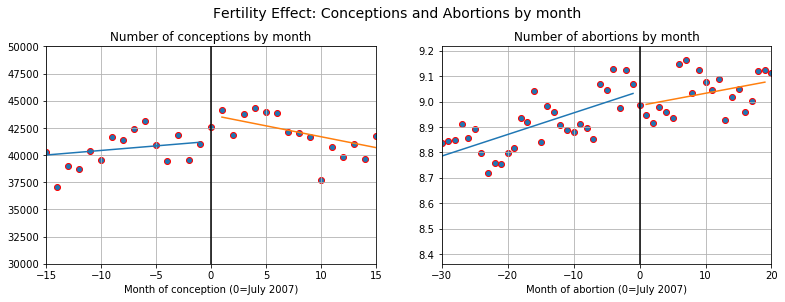

In [4]:
create_fertility_figure()

In the above figure, I deviate slightly from the author's figure since she chose to present the figures at the bimonthly level. However, all her regressions are done at the monthly level. In trying to harmonize the visualization of the relationship between variables with their regression results, I decided to plot the figures at the same frequency in which the analysis has been conducted. Note that this plot nevertheless shows the same patterns as the author's plot.

In [5]:
generate_fertility_results_table()

RDD 10 Years (1) RDD 5 Years (2)  \
Conceptions           Coefficient                   0.0530654       0.0694597   
                      SE                            0.0219492       0.0250128   
                      p-value                        0.015621       0.0054869   
Abortions             Coefficient                   -0.124794       -0.172954   
                      SE                            0.0426989       0.0503841   
                      p-value                      0.00347054     0.000597581   
Specification Details Years Included                  2000-09         2005-09   
                      N                                   120              60   
                      Linear Trend in m                     Y               Y   
                      Quadratic Trend in m                  Y               Y   
                      Cubic Trend in m                      Y               N   
                      No. of days of month                  Y               Y   
                      Calendar Month Dummies                N               N   

                                             RDD 12 Months (3)  \
Conceptions           Coefficient                    0.0851851   
                      SE                             0.0359015   
                      p-value                        0.0176566   
Abortions             Coefficient                    -0.218713   
                      SE                             0.0780549   
                      p-value                       0.00507797   
Specification Details Years Included                   2006-08   
                      N                                     24   
                      Linear Trend in m                      Y   
                      Quadratic Trend in m                   Y   
                      Cubic Trend in m                       N   
                      No. of days of month                   Y   
                      Calendar Month Dummies                 N   

                                             RDD 9 Months (4)  \
Conceptions           Coefficient                   0.0750223   
                      SE                            0.0284876   
                      p-value                      0.00845078   
Abortions             Coefficient                   -0.216493   
                      SE                            0.0612947   
                      p-value                     0.000412419   
Specification Details Years Included                  2006-08   
                      N                                    18   
                      Linear Trend in m                     Y   
                      Quadratic Trend in m                  N   
                      Cubic Trend in m                      N   
                      No. of days of month                  Y   
                      Calendar Month Dummies                N   

                                             RDD 3 Months (5)  \
Conceptions           Coefficient                   0.0503363   
                      SE                            0.0313647   
                      p-value                        0.108523   
Abortions             Coefficient                   -0.130449   
                      SE                            0.0310427   
                      p-value                     2.64277e-05   
Specification Details Years Included                     2007   
                      N                                     6   
                      Linear Trend in m                     N   
                      Quadratic Trend in m                  N   
                      Cubic Trend in m                      N   
                      No. of days of month                  Y   
                      Calendar Month Dummies                N   

                                             DID 10 Years (6) DID 7 Years (7)  \
Conceptions           Coefficient                   0.0495223       0.0539217   
 

The results above are in accordance with equations (1) and (2) described in Empirical Strategy section.

**Note:** In her calculations, the author did not take into account all leap years while creating the 'days of month' variable. She only considered one leap year between 2000 and 2010, when in fact there are 3. Also, while calculating the calendar month of birth, I noticed some errors with her code's 'if' statements. I chose to carry out the correct calculations, and hence my results of specification (1) and (6) are slightly different, but I'm confident they're correct.

In case of abortions, all my coefficient exactly match since the author took all leap years into account here.


---
<a id='expen'></a>
## 4.2. Household Expenditure Results
---

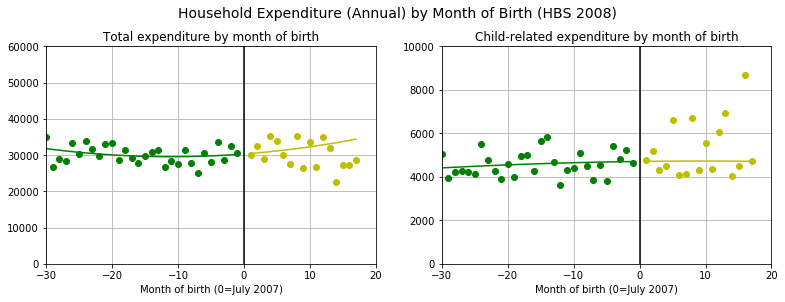

In [6]:
create_fig_hh_expenditure()

In [7]:
generate_expenditure_results_table()

RDD 9m (1)  \
Total Expenditure               Coefficient                       -3175.16   
                                SE                                  2838.3   
                                p-value                           0.263276   
Total Expenditure (log)         Coefficient                      -0.141584   
                                SE                               0.0919987   
                                p-value                           0.123808   
Child-related Expenditure       Coefficient                       -406.931   
                                SE                                  765.67   
                                p-value                           0.595092   
Child-related Expenditure (log) Coefficient                     -0.0108641   
                                SE                                0.195109   
                                p-value                           0.955595   
Durable goods Expenditure       Coefficient                       -1513.26   
                                SE                                 1688.12   
                                p-value                           0.370032   
Durable goods Expenditure (log) Coefficient                       0.157385   
                                SE                                0.297088   
                                p-value                           0.596278   
Specification Details           Linear Trend in m                        Y   
                                Quadratic Trend in m                     Y   
                                Calendar Month of birth dummies          N   
                                Controls                                 Y   
                                Number of months                        18   

                                                                RDD 6m (2)  \
Total Expenditure               Coefficient                       -2247.45   
                                SE                                 2244.17   
                                p-value                           0.316603   
Total Expenditure (log)         Coefficient                      -0.104824   
                                SE                               0.0737887   
                                p-value                           0.155434   
Child-related Expenditure       Coefficient                       -599.337   
                                SE                                 617.533   
                                p-value                           0.331781   
Child-related Expenditure (log) Coefficient                       -0.03442   
                                SE                                0.150885   
                                p-value                           0.819553   
Durable goods Expenditure       Coefficient                       -1849.08   
                                SE                                 1344.74   
                                p-value                           0.169117   
Durable goods Expenditure (log) Coefficient                      0.0254814   
                                SE                                0.238786   
                                p-value                           0.915017   
Specification Details           Linear Trend in m                        Y   
                                Quadratic Trend in m                     N   
                                Calendar Month of birth dummies          N   
                                Controls                                 Y   
                                Number of months                        12   

                                                                RDD 4m (3)  \
Total Expenditure               Coefficient                        404.622   
                                SE                                 2885.45   
                                p-value                           0.888479   
Total 

In this case, we see no significant effects, in accordance with the figure. Also, note that the author had one more column presented here in the paper, but it is based on an extended dataset, which is not publicly available. 


---
<a id='ls'></a>
## 4.3. Labor Supply Outcomes
---

In [8]:
generate_labor_supply_results_table()

RDD 9m (1) RDD 6m (2)  \
Working Last Week     Coefficient                      -0.063596 -0.0430045   
                      SE                               0.0316053  0.0249189   
                      p-value                          0.0441994  0.0843876   
Employed              Coefficient                     -0.0625951 -0.0391909   
                      SE                               0.0308648  0.0243258   
                      p-value                          0.0425562   0.107162   
Specification Details Linear Trend in m                        Y          Y   
                      Quadratic Trend in m                     Y          N   
                      Calendar Month of birth dummies          N          N   
                      Controls                                 Y          Y   
                      Number of months                        18         12   

                                                       RDD 4m (3)  RDD 3m (4)  \
Working Last Week     Coefficient                      -0.0576955   -0.053167   
                      SE                                0.0311374   0.0178908   
                      p-value                           0.0638919  0.00296111   
Employed              Coefficient                      -0.0798807  -0.0534956   
                      SE                                0.0303873   0.0174365   
                      p-value                          0.00856988  0.00215478   
Specification Details Linear Trend in m                         Y           N   
                      Quadratic Trend in m                      N           N   
                      Calendar Month of birth dummies           N           N   
                      Controls                                  Y           Y   
                      Number of months                          8           6   

                                                       RDD 2m (5)  RDD 2m (6)  
Working Last Week     Coefficient                      -0.0547006  -0.0575542  
                      SE                                0.0219407   0.0212667  
                      p-value                           0.0126631  0.00680358  
Employed              Coefficient                      -0.0611544  -0.0610351  
                      SE                                 0.021905   0.0207556  
                      p-value                          0.00524158   0.0032751  
Specification Details Linear Trend in m                         N           N  
                      Quadratic Trend in m                      N           N  
                      Calendar Month of birth dummies           N           N  
                      Controls                                  N           Y  
                      Number of months                          4           4

Here we see that the point estimates are mostly all negative, suggesting that the benefit lead to reduction in labor supply.

---
<a id='cc'></a>
## 4.4. Child Care Outcomes
---

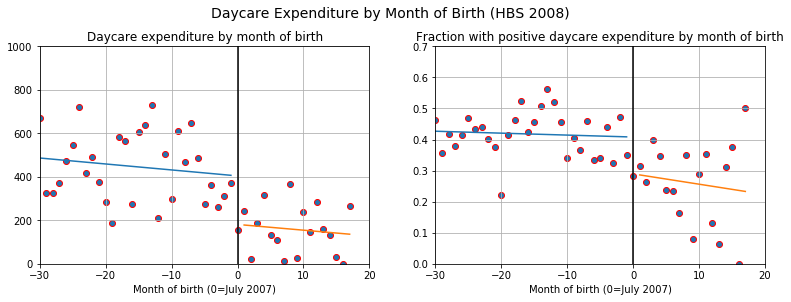

In [3]:
create_daycare_figure()

Note the second figure. There clearly seems to be a time trend or seasonal effect at work here. This is one of the reasons it is important to visualize the relation at a monthly level. The time trend is more stark here. The author's figure, presents it at a bimonthly level, which reduces the prominence. 

In [9]:
generate_childcare_results_table()

RDD 9m (1)  \
Private day care          Coefficient                       -137.915   
                          SE                                  169.54   
                          p-value                            0.41595   
Private day care (binary) Coefficient                     -0.0795217   
                          SE                               0.0939659   
                          p-value                           0.397395   
Specification Details     Linear Trend in m                        Y   
                          Quadratic Trend in m                     Y   
                          Calendar Month of birth dummies          N   
                          Controls                                 Y   
                          Number of months                        18   

                                                          RDD 6m (2)  \
Private day care          Coefficient                       -123.215   
                          SE                                 121.075   
                          p-value                           0.308834   
Private day care (binary) Coefficient                     -0.0985445   
                          SE                               0.0743085   
                          p-value                           0.184789   
Specification Details     Linear Trend in m                        Y   
                          Quadratic Trend in m                     N   
                          Calendar Month of birth dummies          N   
                          Controls                                 Y   
                          Number of months                        12   

                                                          RDD 4m (3)  \
Private day care          Coefficient                       -195.384   
                          SE                                  160.72   
                          p-value                           0.224109   
Private day care (binary) Coefficient                      -0.104124   
                          SE                               0.0937727   
                          p-value                           0.266834   
Specification Details     Linear Trend in m                        Y   
                          Quadratic Trend in m                     N   
                          Calendar Month of birth dummies          N   
                          Controls                                 Y   
                          Number of months                         8   

                                                          RDD 3m (4)  \
Private day care          Coefficient                       -156.693   
                          SE                                 80.0087   
                          p-value                          0.0501769   
Private day care (binary) Coefficient                     -0.0943321   
                          SE                               0.0537889   
                          p-value                           0.079474   
Specification Details     Linear Trend in m                        N   
                          Quadratic Trend in m                     N   
                          Calendar Month of birth dummies          N   
                          Controls                                 Y   
                          Number of months                         6   

                                                          RDD 2m (5)  \
Private day care          Coefficient                       -147.121   
                          SE                                 101.274   
                          p-value                           0.146306   
Private day care (binary) Coefficient                      -0.109559   
                          SE                               0.0624226   
                          p-value                           0.079239   
Specification Details     Linear Trend in m                        N   
                      

**Note:** In column 7 of above table, my calculation and the author's differ. This is due to the exclusion of the interation term between the running variable and treatment indicator by the author in this specification. I discuss this in detail in later sections.

---
<a id='exten'></a>
# 5. Extension(s)
---


---
<a id='speci'></a>
## 5.1. A Closer Look at the DID specification for Child Care Results
---

While working on the replication part of the child care results, I noted that the author mentioned that those results follow the same set of specifications as in the expenditure results. Hence I ran the same calculations (except now with different dependent variables). The results all matched those of the author's, except in the case of the DID specification. Going by the specification details provided in the author's table and in the paper itself, I saw no reason for the discrepancy. 
On inspecting the STATA code however, I noted that this is because the interaction term between the running variable and treatment indicator variable was omitted. The time trend was not allowed to change in that particular specification. This is mentioned by the author in passing, as a footnote, with no indication of where exactly the time trend is not allowed to change before and after the policy. 


So here I separately compute the two specifications; they are identical except for the inclusion of the interaction term between time and treatment dummy, that is the polynomial time trend is allowed to vary pre and post-policy implemtation.

In [4]:
generate_childcare_extension_table()

DID (1)  \
Private day care          Coefficient                                          -176.619   
                          SE                                                    83.5973   
                          p-value                                             0.0346231   
Private day care (binary) Coefficient                                         -0.036358   
                          SE                                                  0.0499607   
                          p-value                                              0.466778   
Specification Details     Interacting Running Variable (months) with Trea...          N   
                          Linear Trend in m                                           Y   
                          Quadratic Trend in m                                        Y   
                          Calendar Month of birth dummies                             Y   
                          Controls                                                    Y   
                          Number of months                                           48   

                                                                                DID (2)  
Private day care          Coefficient                                          -107.566  
                          SE                                                    125.126  
                          p-value                                              0.389977  
Private day care (binary) Coefficient                                          0.024353  
                          SE                                                  0.0717752  
                          p-value                                              0.734387  
Specification Details     Interacting Running Variable (months) with Trea...          Y  
                          Linear Trend in m                                           Y  
                          Quadratic Trend in m                                        Y  
                          Calendar Month of birth dummies                             Y  
                          Controls                                                    Y  
                          Number of months                                           48

On inspecting the table above, it becomes somewhat transparent why the author may have chosen to not report the estimates including the interaction terms. A quick glance at the p-values for 'Private day care' as dependent variable tells us the estimate is not at all significant when the polynomial time trend is allowed to change before and after the policy. On the other hand, it is significant without the interaction term. Also, it has a higher negative magnitude.

From her day care estimates, the author, in the paper, concluded that the policy had a negative effect on overall day care usage for families that received the treatment. However, this claim does not hold up if we allow for the interaction terms, as we do in all other similar specifications of this paper.

This posits a very important caveat to the author's conclusions on the effect of the policy on day care usage, and mentions a merit in the paper. Otherwise, readers have no way to know unless they decide to closely inspect the code.

<a id='acf'></a>
---
## 5.2. Visual Check: Presence of Autocorrelation in the Time Series
---

Hausman and Rapson (2018) discuss the issue of the time series displaying serial dependence. There are two aspects - serial dependence in the dependent variable, and serial dependence in the residuals of our regressions. I present a visual check for possible autocorrelation in the dependent variables (I restrict my focus to the conceptions and abortions data).

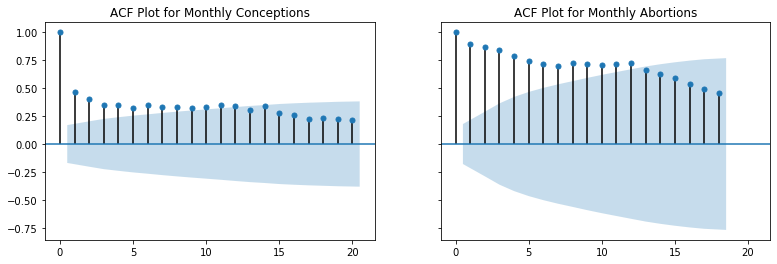

In [22]:
fig, axs = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True, figsize=(13,4))
sm.graphics.tsaplots.plot_acf(df1["number_conceptions"], lags = 20, alpha = 0.05, ax = axs[0])
axs[0].set_title('ACF Plot for Monthly Conceptions')
sm.graphics.tsaplots.plot_acf(df2["number_abortions"], lags = 18, alpha = 0.05, ax = axs[1])
axs[1].set_title('ACF Plot for Monthly Abortions')

plt.show()


There appears to be statistically significant autocorrelation amongst the monthly conceptions data for upto lags of around 6. The time series for monthly abortions seems to be highly autocorrelated. Note how the effect of seasonality in conceptions and abortions patterns is also fairly visible, with values of lag 12 showing high serial dependence.

---
<a id='refs'></a>
# References
---

Hausman, C., & Rapson, D. S. (2018). Regression discontinuity in time: Considerations for empirical applications. Annual Review of Resource Economics, 10, 533-552.

Morgan, S. L., & Winship, C. (2015). Counterfactuals and causal inference. Cambridge University Press.

González, L. (2013). The effect of a universal child benefit on conceptions, abortions, and early maternal labor supply. American Economic Journal: Economic Policy, 5(3), 160-88.